## **Binary Image Classification Using Convolutional Neural Networks: Part I**

This section involves developing a binary image classification model to distinguish between two categories: "cat" and "non-cat." The dataset comprises labeled images stored in HDF5 files, divided into training and test sets. Our objective is to train a Convolutional Neural Network (CNN) using PyTorch, evaluate its performance, and analyze its misclassifications to identify challenges in classification.

We chose CNNs for their ability to extract hierarchical spatial features from images, making them highly effective for tasks like image classification. The network that we implement consists of convolutional, pooling, and fully connected layers, which progressively learn and classify image patterns.

Key components include:
- **Data normalization**: Images are normalized to scale pixel values between 0 and 1, improving convergence during training.
- **Binary cross-entropy loss**: Used to quantify the difference between predicted probabilities and true labels.
- **Adam optimizer**: Efficiently updates model weights to minimize the loss function.
- **Performance analysis**: The model's performance is assessed, and misclassifications are visualized to evaluate its limitations.


# **Code**


**Loading and Preprocessing the Dataset**

The `h5py` library was used to extract the images and labels stored in the HDF5 files. Since the raw pixel values of the images range from 0 to 255, the images were normalized by dividing the pixel values by 255. This normalization was crucial for ensuring that all input features were on a similar scale, which helps accelerate convergence during training. The images were then converted into PyTorch tensors and permuted to follow PyTorch’s standard input format $[C, H, W]$, where $C$ represents the number of channels, $H$ the height, and $W$ the width of the images. This arrangement was necessary because PyTorch’s convolutional layers expect inputs in this format. Additionally, the labels were converted into PyTorch tensors. The datasets were subsequently wrapped into `DataLoader` objects, enabling efficient batching and shuffling. Batching improved computational efficiency by allowing multiple samples to be processed simultaneously, while shuffling ensured that the model would not learn spurious correlations from the order of the training data.

In [2]:
# Import necessary libraries
from google.colab import drive
import h5py
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt

In [29]:
# Mount Google Drive to access files stored there
drive.mount('/content/drive')

# Load the training and testing HDF5 files from Google Drive
train_file = h5py.File('/content/drive/My Drive/Colab Notebooks/train_catvnoncat.h5', 'r')
test_file = h5py.File('/content/drive/My Drive/Colab Notebooks/test_catvnoncat.h5', 'r')

# Extract image data and labels from the HDF5 files
train_images = np.array(train_file['train_set_x']) / 255.0  # Normalize pixel values to range [0, 1]
train_labels = np.array(train_file['train_set_y'])
test_images = np.array(test_file['test_set_x']) / 255.0  # Normalize pixel values to range [0, 1]
test_labels = np.array(test_file['test_set_y'])

# Close the HDF5 files after data extraction
train_file.close()
test_file.close()

# Convert the data to PyTorch tensors
# Images need to be permuted to match PyTorch's [N, C, H, W] format (N: batch size, C: channels, H: height, W: width)
train_images = torch.tensor(train_images, dtype=torch.float32).permute(0, 3, 1, 2)  # [N, C, H, W]
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_images = torch.tensor(test_images, dtype=torch.float32).permute(0, 3, 1, 2)
test_labels = torch.tensor(test_labels, dtype=torch.long)

# Create DataLoader objects for batching the data during training and testing
train_dataset = TensorDataset(train_images, train_labels)  # Combine images and labels into a dataset
test_dataset = TensorDataset(test_images, test_labels)

# Set up DataLoaders to handle batching, shuffling for training, and no shuffling for testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Model Architecture: Convolutional Neural Network (CNN)**

The architecture comprised three convolutional layers, each followed by a ReLU activation function and a max-pooling layer. The convolutional layers were responsible for extracting spatial features from the input images, learning patterns such as edges, textures, and shapes. The ReLU activation function introduced non-linearity, enabling the network to model complex patterns, while max-pooling reduced the spatial dimensions of the feature maps, retaining the most important features and improving computational efficiency. Following the convolutional layers, two fully connected layers were included. These layers acted as classifiers, mapping the extracted features to a binary output. The final layer used a sigmoid activation function, which output a probability score indicating whether an image belonged to the "cat" class. The design of the network was informed by the hierarchical nature of CNNs, making them particularly effective for image classification tasks.


In [25]:
import torch.nn as nn
import torch.nn.functional as F

class CatVsNonCatCNN(nn.Module):
    def __init__(self):
        super(CatVsNonCatCNN, self).__init__()

        # Convolutional layers: These layers learn spatial hierarchies from the images
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  # 3 input channels (RGB), 16 output channels
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # 16 input channels, 32 output channels
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # 32 input channels, 64 output channels

        # Initialize fully connected (fc) layer dimensions based on the output of the convolutions
        self._initialize_fc()

        # Fully connected layers: These layers make predictions based on learned features
        self.fc1 = nn.Linear(self.flatten_size, 128)  # Input size is calculated in _initialize_fc()
        self.fc2 = nn.Linear(128, 1)  # Output layer for binary classification (1 output unit)

    def _initialize_fc(self):
        # Create a dummy input tensor to calculate the size of the output from the convolutional layers
        example_input = torch.zeros(1, 3, 64, 64)  # Batch size of 1, 3 channels (RGB), 64x64 image size
        # Pass through the convolutional layers with max pooling to simulate forward pass
        x = F.max_pool2d(F.relu(self.conv1(example_input)), 2, 2)  # First convolution, then max pooling
        x = F.max_pool2d(F.relu(self.conv2(x)), 2, 2)  # Second convolution, then max pooling
        x = F.max_pool2d(F.relu(self.conv3(x)), 2, 2)  # Third convolution, then max pooling
        # Calculate the flattened size after the convolutions and pooling
        self.flatten_size = x.numel()  # Number of elements in the tensor

    def forward(self, x):
        # Forward pass through the convolutional layers and max pooling layers
        x = F.relu(self.conv1(x))  # Apply ReLU activation to first convolution
        x = F.max_pool2d(x, 2, 2)  # Max pooling to reduce dimensionality
        x = F.relu(self.conv2(x))  # Apply ReLU activation to second convolution
        x = F.max_pool2d(x, 2, 2)  # Max pooling to reduce dimensionality
        x = F.relu(self.conv3(x))  # Apply ReLU activation to third convolution
        x = F.max_pool2d(x, 2, 2)  # Max pooling to reduce dimensionality
        # Flatten the tensor for input into fully connected layers
        x = x.view(x.size(0), -1)  # Flatten the output (preserving the batch size)
        # Forward pass through fully connected layers
        x = F.relu(self.fc1(x))  # Apply ReLU activation to first fully connected layer
        x = torch.sigmoid(self.fc2(x))  # Sigmoid activation for binary classification output
        return x  # Output probabilities for the binary classification


**Training the Model**

To train the network, the binary cross-entropy loss function was used, as it is well-suited for binary classification problems and quantifies the error between the predicted probabilities and the true labels. The Adam optimizer was chosen for its adaptive learning rate and momentum properties, ensuring stable and efficient convergence. Training occurred over multiple epochs. In each epoch, the model performed forward propagation to compute predictions, followed by loss computation. Backpropagation was then used to calculate gradients, which were applied by the optimizer to adjust the model's weights. After each epoch, the average loss was recorded and reported, allowing for monitoring of the model’s learning progress.

In [26]:
# Set the device to use CPU
device = torch.device('cpu')

# Initialize the model, move it to the appropriate device (GPU/CPU)
model = CatVsNonCatCNN().to(device)

# Define the loss function: Binary Cross-Entropy (BCELoss) for binary classification
criterion = nn.BCELoss()

# Initialize the optimizer: Adam optimizer with a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the number of epochs for training
epochs = 35

# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0  # Track the loss for the current epoch

    # Iterate through the training dataset in batches
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()  # Move data to the device (GPU/CPU)

        # Forward pass: Compute predicted outputs by passing images through the model
        outputs = model(images).squeeze()  # Remove extra dimensions and get predictions
        loss = criterion(outputs, labels)  # Calculate the loss between predictions and true labels

        # Backward pass: Compute gradients for model parameters
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Compute the gradient of the loss
        optimizer.step()  # Update model parameters using the computed gradients

        # Accumulate the loss for the current batch
        running_loss += loss.item()

    # Print the average loss for the current epoch
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/35, Loss: 0.6748
Epoch 2/35, Loss: 0.6493
Epoch 3/35, Loss: 0.6340
Epoch 4/35, Loss: 0.6117
Epoch 5/35, Loss: 0.5877
Epoch 6/35, Loss: 0.5605
Epoch 7/35, Loss: 0.5118
Epoch 8/35, Loss: 0.4516
Epoch 9/35, Loss: 0.3985
Epoch 10/35, Loss: 0.3764
Epoch 11/35, Loss: 0.3756
Epoch 12/35, Loss: 0.3169
Epoch 13/35, Loss: 0.3157
Epoch 14/35, Loss: 0.3328
Epoch 15/35, Loss: 0.3516
Epoch 16/35, Loss: 0.3473
Epoch 17/35, Loss: 0.3219
Epoch 18/35, Loss: 0.3653
Epoch 19/35, Loss: 0.3142
Epoch 20/35, Loss: 0.2553
Epoch 21/35, Loss: 0.2491
Epoch 22/35, Loss: 0.2497
Epoch 23/35, Loss: 0.2895
Epoch 24/35, Loss: 0.2575
Epoch 25/35, Loss: 0.2996
Epoch 26/35, Loss: 0.2511
Epoch 27/35, Loss: 0.2244
Epoch 28/35, Loss: 0.2174
Epoch 29/35, Loss: 0.2377
Epoch 30/35, Loss: 0.2011
Epoch 31/35, Loss: 0.1398
Epoch 32/35, Loss: 0.1465
Epoch 33/35, Loss: 0.1282
Epoch 34/35, Loss: 0.1266
Epoch 35/35, Loss: 0.1476


**Model Evaluation and Error Analysis**

After training, the model's performance was evaluated on the test set. To ensure consistent and deterministic predictions, the model was switched to evaluation mode, which disabled any training-specific behavior, such as dropout. During evaluation, the model’s predictions were compared to the true labels, and instances of misclassification were identified. These misclassified samples were particularly valuable as they provided insights into the model’s limitations. The indices of the incorrect predictions were recorded for further analysis.


**Visualizing Misclassified Cases**

Finally, a visual examination of the misclassified cases was performed. At least four random examples from the set of misclassified images were selected and displayed, along with their true and predicted labels. This step was essential for diagnosing potential issues in the dataset or the model. For instance, some images might have been ambiguous or contained noise, making them challenging for the model to classify accurately.


Accuracy on test set: 78.00%
Indices of incorrect predictions in the test set: [5, 20, 21, 29, 35, 39, 41, 43, 46, 47, 48]


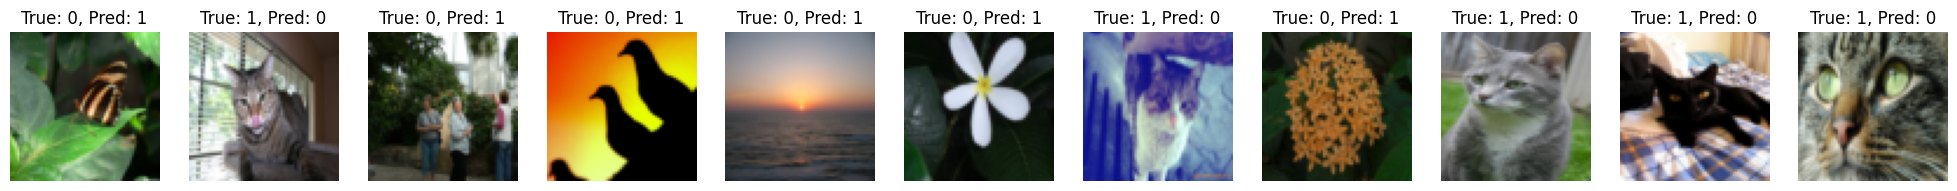

In [30]:
# Set the model to evaluation mode (turn off dropout, batch normalization, etc.)
model.eval()

# Initialize variables to track correct predictions and total samples
correct = 0
total = 0

# Initialize lists to store information about incorrect predictions
incorrect_indices = []  # List to store indices of incorrect predictions
incorrect_images = []   # List to store images of incorrect predictions
incorrect_labels = []   # List to store true labels of incorrect predictions
incorrect_preds = []    # List to store predicted labels of incorrect predictions

# Disable gradient calculations for inference to save memory and computations
with torch.no_grad():
    # Iterate through the test dataset in batches
    for idx, (images, labels) in enumerate(test_loader):
        # Move images and labels to the appropriate device (GPU/CPU)
        images, labels = images.to(device), labels.to(device)

        # Perform forward pass: Compute model outputs
        outputs = model(images).squeeze()  # Remove extra dimensions from the output tensor

        # Convert the outputs to binary predictions (using threshold 0.2)
        predictions = (outputs > 0.2).long()  # Sigmoid output thresholding for binary classification

        # Count correct predictions
        correct += (predictions == labels).sum().item()
        # Count total samples processed
        total += labels.size(0)


        # Identify mismatches (incorrect predictions)
        mismatches = (predictions != labels).cpu().numpy()  # Compare predictions with true labels
        batch_indices = np.where(mismatches)[0]  # Find indices of mismatched predictions within the batch

        # Store indices, images, labels, and predictions of incorrect cases
        incorrect_indices.extend(batch_indices + idx * test_loader.batch_size)  # Adjust indices for the full dataset
        incorrect_images.extend(images[batch_indices].cpu().numpy())  # Store images of incorrect predictions
        incorrect_labels.extend(labels[batch_indices].cpu().numpy())  # Store true labels of incorrect predictions
        incorrect_preds.extend(predictions[batch_indices].cpu().numpy())  # Store predicted labels of incorrect predictions

# Calculate and print the accuracy on the test set
print(f"Accuracy on test set: {100 * correct / total:.2f}%")

# Print the indices of incorrect predictions
print("Indices of incorrect predictions in the test set:", incorrect_indices)

# Visualize a few failed cases to better understand model errors
num_to_display = max(4, len(incorrect_images))  # Ensure at least 4 images are displayed
fig, axs = plt.subplots(1, num_to_display, figsize=(25, 15))

# Loop through the incorrect predictions and display the corresponding images
for i in range(num_to_display):
    # Convert image from [C, H, W] format to [H, W, C] for correct visualization
    image = incorrect_images[i].transpose(1, 2, 0)  # [C, H, W] -> [H, W, C]
    true_label = incorrect_labels[i]  # Get the true label
    pred_label = incorrect_preds[i]  # Get the predicted label

    # Display the image with a title indicating true and predicted labels
    axs[i].imshow(image)
    axs[i].set_title(f"True: {true_label}, Pred: {pred_label}")  # Title with true and predicted labels
    axs[i].axis('off')  # Hide axes for better visual presentation

# Show the visualization of incorrect predictions
plt.show()


# **Conclusions**

To improve the classification of the Cat vs NonCat image set we could modify the CNN model to be denser and better able to learn the characteristics of the images. The misclassification problems seem to occur when the background of the image is of a color similar to the cat or when an image has colors characteristic of a cat's fur.